# Generating Geo Map

## Import libraries

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import seaborn as sns
import geoplot as gplt
from shapely.ops import cascaded_union
from shapely import wkt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Import Data

In [2]:
# URL = 'http://opendata.hcmgis.vn/geoserver/wfs?srsName=EPSG%3A4326&typename=geonode%3Avietnam_districts&outputFormat=json&version=1.0.0&service=WFS&request=GetFeature'

# Read geo data, might take a bit
raw = pd.read_csv('./vn_geomap.csv')

In [3]:
# Transfrom Pandas df to GeoPandas df
def transform_to_geopandas(row):
    try:
        return wkt.loads(row)[0]
    except:
        return 'Error'
    


In [4]:
raw['geometry'] = raw['geometry'].apply(transform_to_geopandas)
raw = raw[raw['geometry'] != 'Error']

ParseException: Expected number but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected number but encountered end of stream


In [6]:
# Run this cell to restore to the original data
geo_data = gpd.GeoDataFrame(raw, geometry='geometry')

In [8]:
# Generate some test data (Delete this cell if you have already run the above cell)
random_livestock = np.random.random(geo_data.shape[0])
geo_data['livestock'] = random_livestock

random_num = np.random.random(geo_data.shape[0])
geo_data['feed'] = random_num
# -------------------------

geo_data.head()

,Name,Province,geometry,livestock,feed
0,Luc Ngan District,Bac Giang Province,"POLYGON ((106.67794 21.60274, 106.68375 21.602...",0.109202,0.582276
1,Son Dong District,Bac Giang Province,"POLYGON ((106.84323 21.50239, 106.84381 21.498...",0.130483,0.402926
2,Bach Long Vi District,Hai Phong City,"POLYGON ((107.74571 20.17040, 107.74642 20.166...",0.443388,0.894442
3,Con Co District,Quang Tri Province,"POLYGON ((107.34309 17.14976, 107.34306 17.149...",0.202335,0.661524
4,Ba Dinh District,Ha Noi City,"POLYGON ((105.84924 21.05438, 105.85635 21.042...",0.677511,0.937432


## Data Preprocessing

### Combine two provinces together

In [9]:
# Combine two provinces together
def combine_province(province, new_name):
    
    combined_data = geo_data[geo_data.Province.isin([*province])]
    
    if new_name == False:
        new_name = combined_data['Province'].value_counts().index[0] + ' & ' + combined_data['Province'].value_counts().index[1] 
        
    new_geometry = cascaded_union([combined_data.iloc[0]['geometry'], combined_data.iloc[1]['geometry']])[0]
    
    new_livestock = combined_data.iloc[0]['livestock'] + combined_data.iloc[1]['livestock'] 
    
    new_feed = combined_data.iloc[0]['feed'] + combined_data.iloc[1]['feed'] 
   
    combined_data = geo_data[~geo_data.Province.isin([*province])]
    combined_data = combined_data.append(pd.DataFrame([[new_name, new_name, new_geometry, new_livestock, new_feed]], columns = combined_data.columns))
    
    return combined_data.reset_index().drop(columns = 'index')

In [10]:
# --------- EDIT THIS ---------
PROVINCES = 'Tay Ninh Province', 'Dong Nai Province'
NEW_PROVINCE_NAME = False # If set to False, concatenate two district names together
# -----------------------------

# Then run,...
geo_data = combine_province(PROVINCES, NEW_PROVINCE_NAME)
geo_data.tail()

,Name,Province,geometry,livestock,feed
686,Phu Tan District,Ca Mau Province,"POLYGON ((104.93299 9.00507, 104.93549 8.99980...",0.336462,0.283468
687,Ngoc Hien District,Ca Mau Province,"POLYGON ((104.87905 8.38158, 104.87814 8.38136...",0.490633,0.427065
688,Con Dao District,Ba Ria - Vung Tau Province,"POLYGON ((106.55782 8.63026, 106.55872 8.62917...",0.300729,0.432738
689,Hoang Sa District,Da Nang City,"POLYGON ((111.21334 15.80669, 111.21581 15.805...",0.300696,0.315987
690,Dong Nai Province & Tay Ninh Province,Dong Nai Province & Tay Ninh Province,"POLYGON ((107.15720 10.89927, 107.15829 10.897...",1.867240,0.773677


### Combine two districts in the same province

In [13]:
# Combine two districts in the same province
def combine_district(districts, province, new_name):
    
    combined_data = geo_data[(geo_data.Name.isin([*districts])) & (geo_data.Province == province)]
    
    if new_name == False:
        new_name = combined_data.iloc[0]['Name'] + ' & ' + combined_data.iloc[1]['Name'] 
        
    new_geometry = cascaded_union([combined_data.iloc[0]['geometry'], combined_data.iloc[1]['geometry']])
    
    new_livestock = combined_data.iloc[0]['livestock'] + combined_data.iloc[1]['livestock'] 
    
    new_feed = combined_data.iloc[0]['feed'] + combined_data.iloc[1]['feed'] 
   
    combined_data = geo_data[~((geo_data.Name.isin([*districts])) & (geo_data.Province == province))]
    combined_data = combined_data.append(pd.DataFrame([[new_name, province, new_geometry, new_livestock, new_feed]], columns = combined_data.columns))
    
    return combined_data.reset_index().drop(columns = 'index')

In [14]:
# --------- EDIT THIS ---------
DISTRICTS = 'District 7', 'District 8' # Input two districts only
PROVINCE = 'Ho Chi Minh City'
NEW_DISTRICT_NAME = 'District 7 & 8' # If set to False, concatenate two district names together
# -----------------------------

# Then run,...
geo_data = combine_district(DISTRICTS, PROVINCE, NEW_DISTRICT_NAME)
geo_data.tail()

,Name,Province,geometry,livestock,feed
685,Ngoc Hien District,Ca Mau Province,"POLYGON ((104.87905 8.38158, 104.87814 8.38136...",0.490633,0.427065
686,Con Dao District,Ba Ria - Vung Tau Province,"POLYGON ((106.55782 8.63026, 106.55872 8.62917...",0.300729,0.432738
687,Hoang Sa District,Da Nang City,"POLYGON ((111.21334 15.80669, 111.21581 15.805...",0.300696,0.315987
688,Dong Nai Province & Tay Ninh Province,Dong Nai Province & Tay Ninh Province,"POLYGON ((107.15720 10.89927, 107.15829 10.897...",1.867240,0.773677
689,District 7 & 8,Ho Chi Minh City,"POLYGON ((106.69197 10.74156, 106.68283 10.739...",0.779825,0.512006


### Generate coordinates from geo data

In [15]:
# Generate coordinates from geometry
geo_data['coords'] = geo_data['geometry'].apply(lambda x: x.representative_point().coords[:])
geo_data['coords'] = [coords[0] for coords in geo_data['coords']]

## Generate Geo Map with Livestock & Feed data

In [16]:
# Select one or more provinces to plot
def select_plot_data(provinces):
    
    return geo_data[geo_data['Province'].isin(provinces)]

# Generate geo map
def generate_map(provinces, hue_data, palette, image_size, show_label, excluded_districts, label_size, space_1st_row, space_2nd_row, show_legend):
 
    plot_data = select_plot_data(provinces)
    
    gplt.choropleth(plot_data, hue = plot_data[hue_data], cmap=palette, figsize = image_size, legend = show_legend)
    
    if show_label:
        for idx, row in plot_data.iterrows():
            if row['Name'] not in excluded_districts:
                plt.text(s=row['Name'], x = row['coords'][0], y = row['coords'][1],
                             horizontalalignment='center', fontdict = {'weight': 'bold', 'size': label_size})
                plt.text(s='Livestock: ' + str(round(row['livestock'],2)), x=row['coords'][0],y = row['coords'][1] - space_1st_row,
                             horizontalalignment='center', fontdict = {'size': label_size})
                plt.text(s='Feed: ' + str(round(row['feed'],2)), x=row['coords'][0],y = row['coords'][1] - space_1st_row - space_2nd_row ,
                         horizontalalignment='center', fontdict = {'size': label_size})
    plt.show()

__Note:__ You can save the plot as an image but right-clicking the plot then `Save image as...`

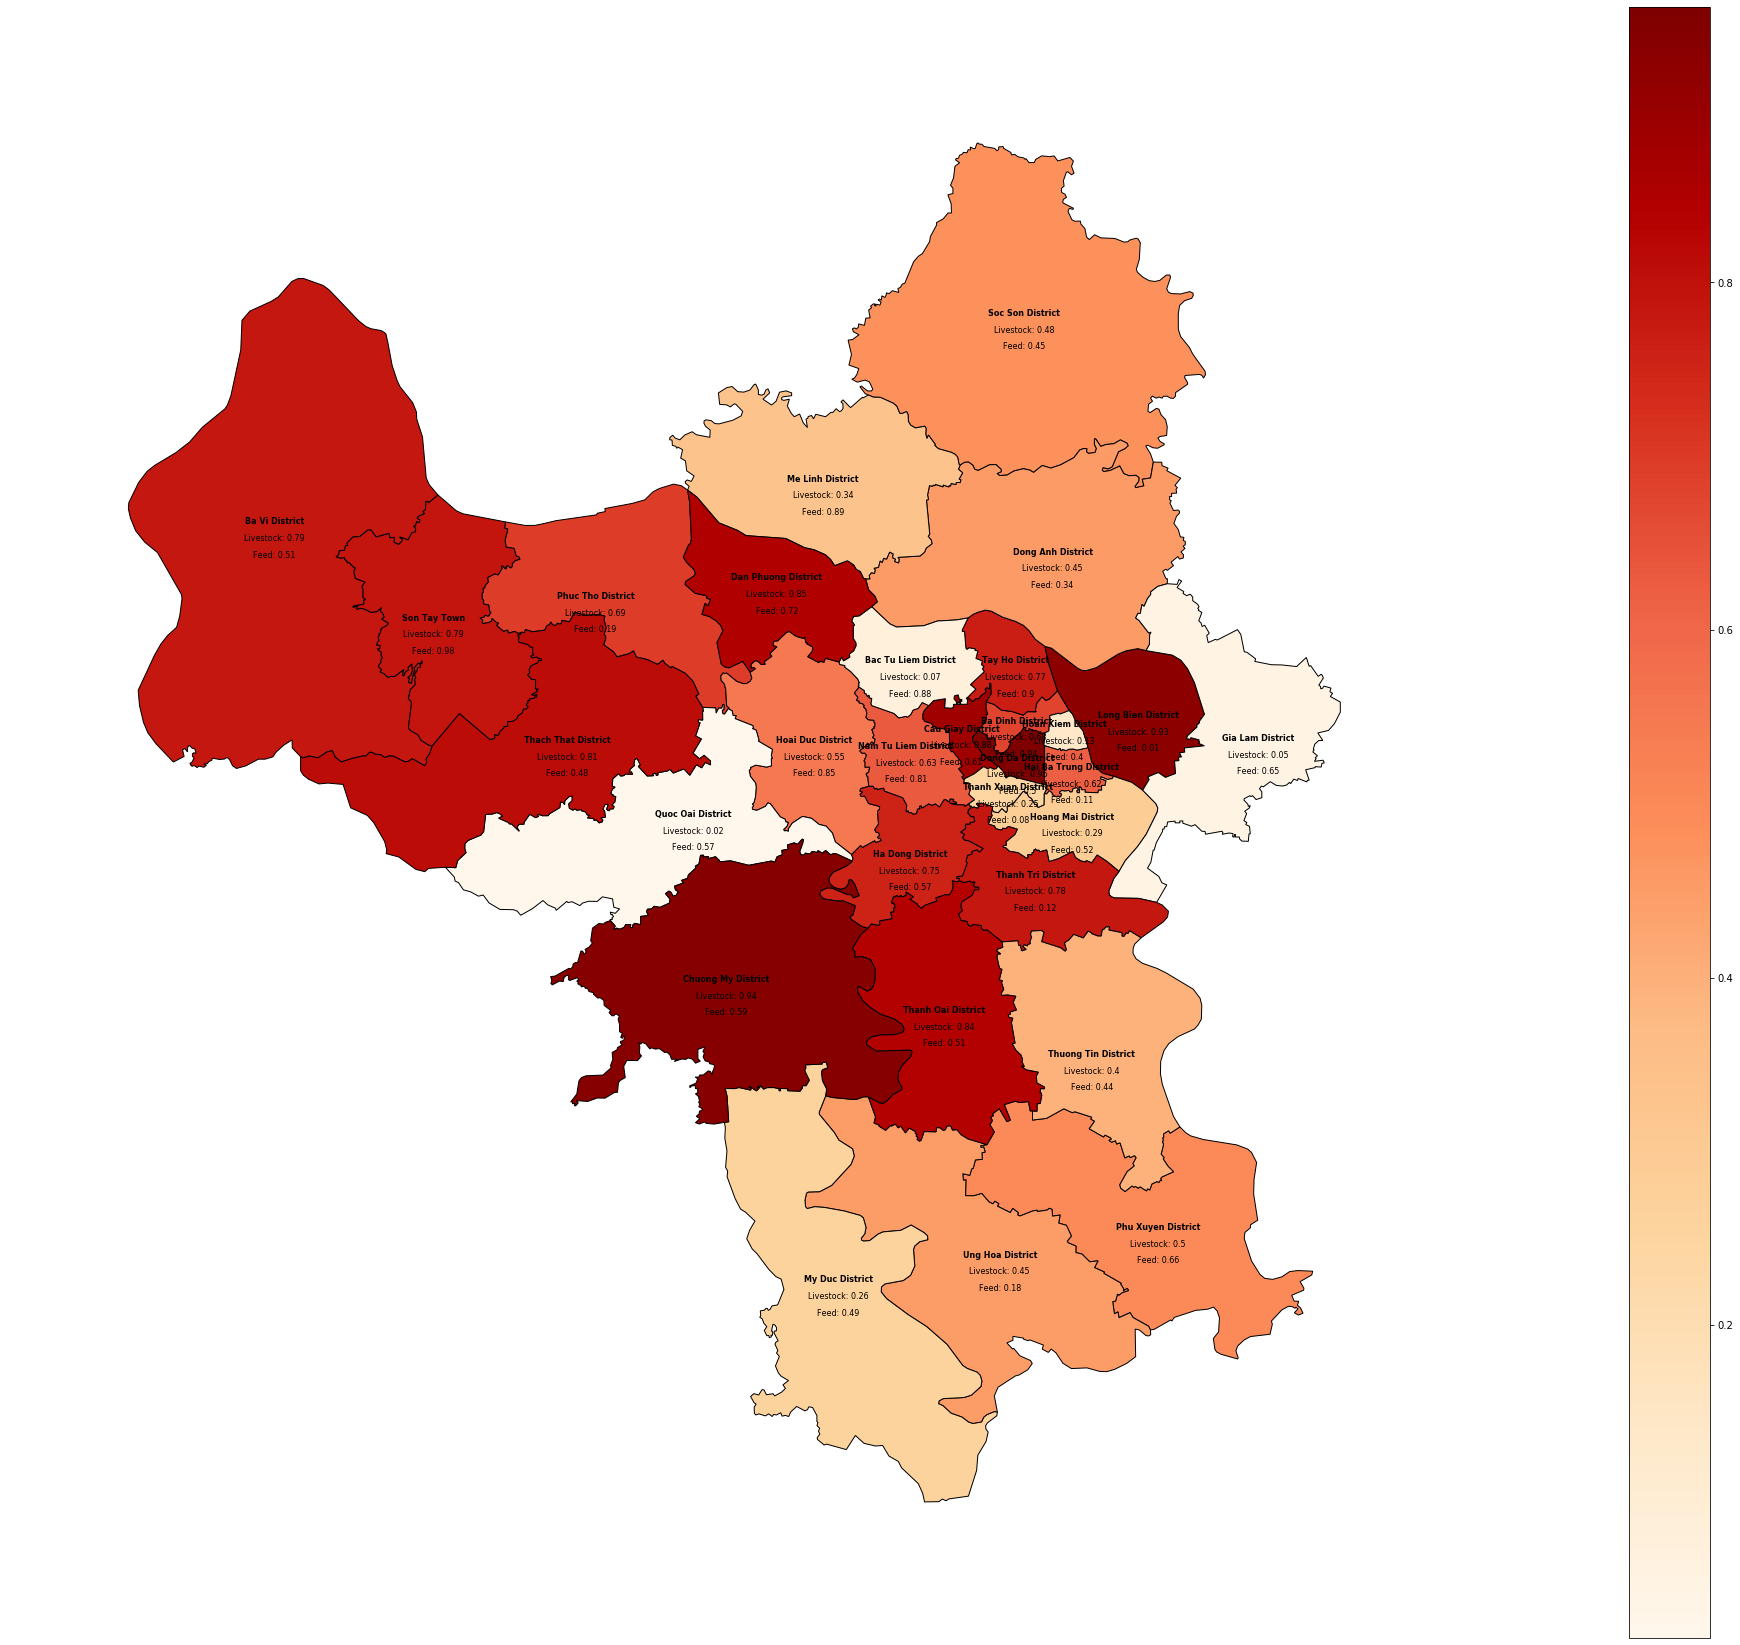

In [17]:
# --------- EDIT THIS ---------
PROVINCES = ['Ha Noi City'] # Plot the data of given provinces, must be a list
HUE_DATA =  'livestock' # Metric used to color code
PALETTE = 'OrRd' # Color Gradient, find more here: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
IMAGE_SIZE = (60,30)
SHOW_LABEL = True # Show/hide all labels
EXCLUDED_DISTRICTS = [] # Hide the labels of given districts, must be a list
LABEL_SIZE = 8 # Font size of label
SPACE_1ST_ROW = 0.01 # Space between District name label and Livestock data label
SPACE_2ND_ROW = 0.01 # Space between Livestock data label and Feed data label
SHOW_LEGEND = True # Show/hide legend
# -----------------------------

# Then run,...
generate_map(PROVINCES, HUE_DATA,PALETTE, IMAGE_SIZE, SHOW_LABEL, EXCLUDED_DISTRICTS, LABEL_SIZE, SPACE_1ST_ROW, SPACE_2ND_ROW, SHOW_LEGEND)